# 时间序列分析

### 第一步,首先导入数据,并且进行初步预览

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

sns.set()
warnings.filterwarnings('ignore')

In [2]:
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

In [24]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [11]:
import os

os.chdir(r"D:\pycharm-python\datasets")
ad = pd.read_csv(
    r'ads.csv',
    index_col=['Time'],
    parse_dates=['Time']
)
ad

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
...,...
2017-09-21 19:00:00,155890
2017-09-21 20:00:00,123395
2017-09-21 21:00:00,103080


In [12]:
currency = pd.read_csv(r'currency.csv', index_col='Time', parse_dates=['Time'])
currency

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775
...,...
2018-02-20,2166449
2018-02-21,1552313
2018-02-22,2175548


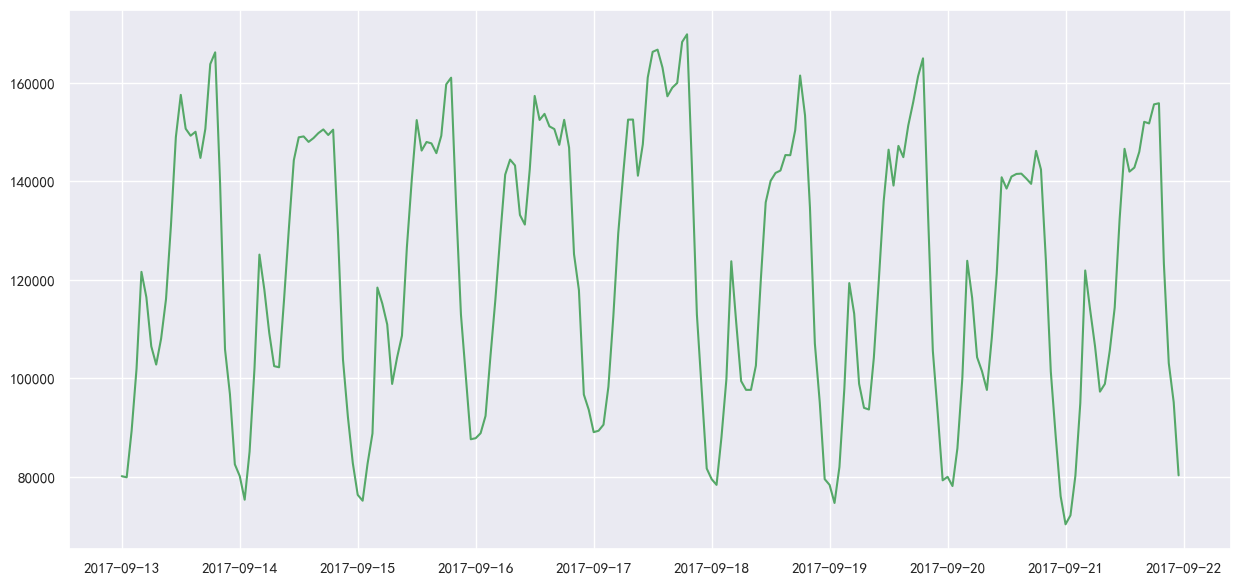

In [13]:
plt.figure(figsize=(15, 7))
plt.grid(True)
plt.plot(ad, c='g')

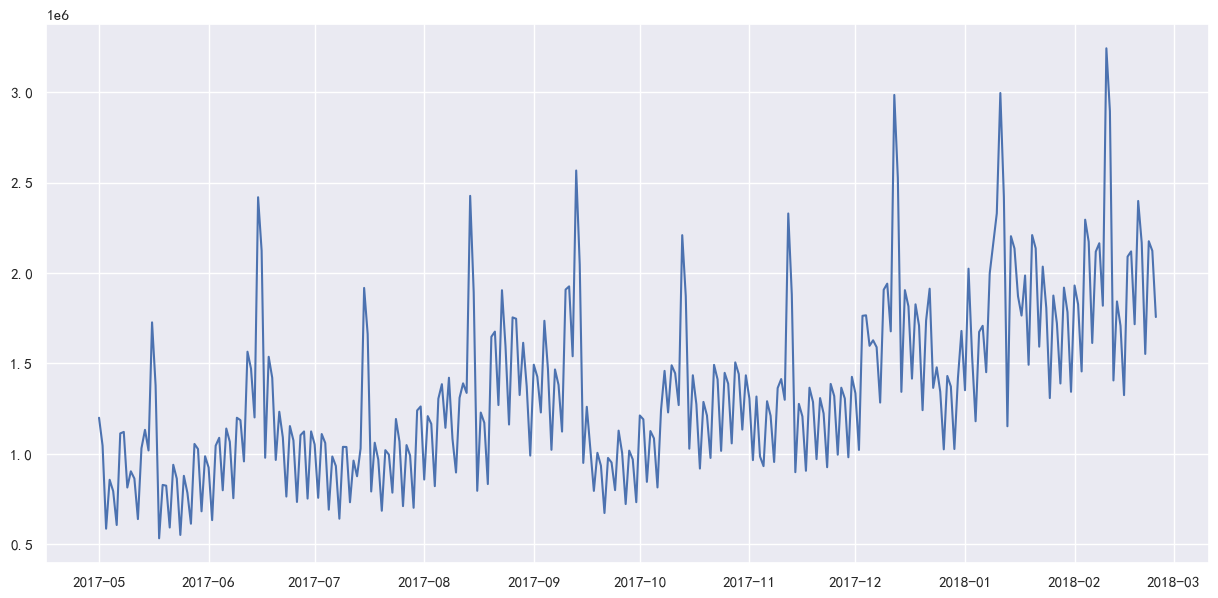

In [14]:
plt.figure(figsize=(15, 7))
plt.tight_layout()
plt.plot(currency)

### 第二步,移动,平滑,评估

In [58]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, \
    mean_squared_log_error

2.1 moving average,假设未来的某个值,受过去所有时间的数值所决定.也就是之前k个数值的期望值.*但是这种方式不适用于长期的预测.*

In [59]:
def moving_average(series, n):
    return np.average(series[-n:])


moving_average(ad, 24)

116805.0

In [60]:
def plotMovingAverage(series, window, plot_interval=False, scale=1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17, 10))
    plt.title('当移动窗口为{}时的平滑模型'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    if plot_interval:  # 绘制置信区间
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(
            series[window:] - rolling_mean[window:])  #np.std():Compute the standard deviation along the specified axis.
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, 'r--', label='upper bond/lower bond')
        plt.plot(lower_bond, 'r--')

        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, 'ro', markersize=10)

    plt.plot(series[window:], label='Actual Values')
    plt.legend(loc='upper left')
    plt.grid(True)

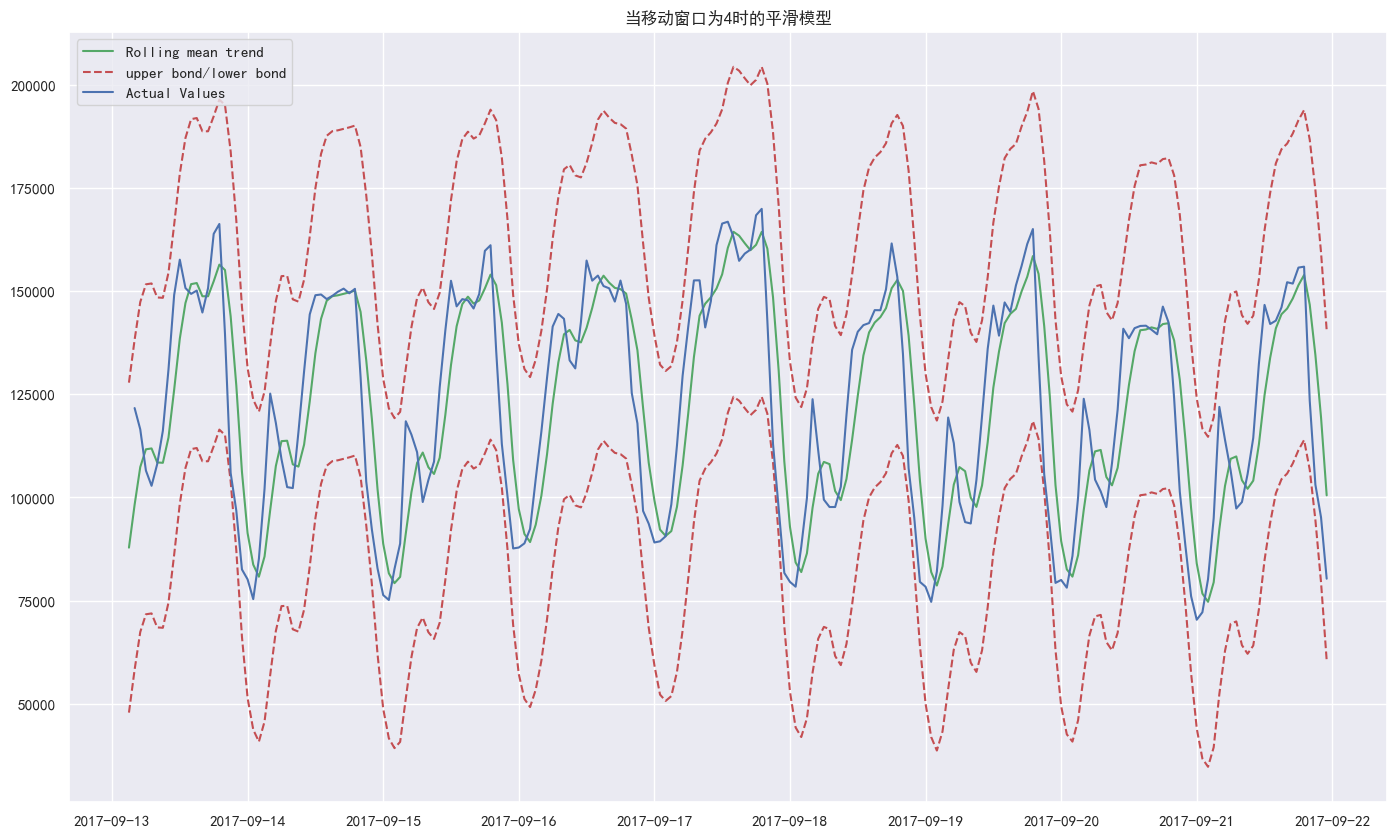

In [61]:
plotMovingAverage(series=ad, window=4, plot_anomalies=True, plot_interval=True)

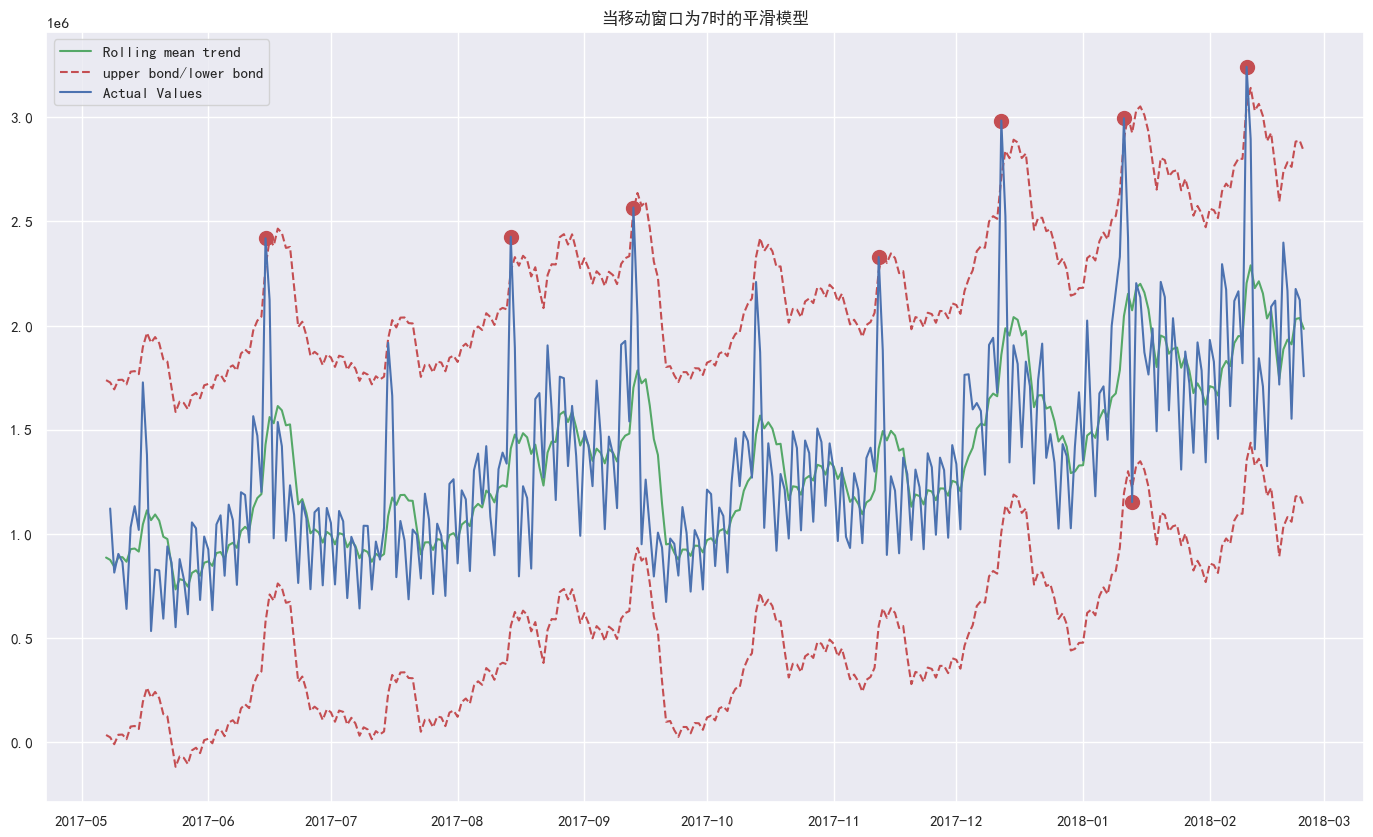

In [62]:
plotMovingAverage(series=currency, window=7, plot_interval=True, plot_anomalies=True)

**观察上面的图形我们发现,对于季节性出现的峰值标记为了异常值.所以我们进行如下改进:不再简单取window个步长的直接平均值,而是取加权平均值**

In [63]:
def weighted_average(series, weights):
    """
    :param series: 时间序列
    :param weights:权重矩阵
    :return:序列的加权平均值
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)


weighted_average(ad, [0.6, 0.3, 0.1])

98423.0

In [64]:
# ad.iloc[-2]
ad

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
...,...
2017-09-21 19:00:00,155890
2017-09-21 20:00:00,123395
2017-09-21 21:00:00,103080


In [65]:
# ad.iloc[-0-1]


#### 指数平滑
**如果不再简单使用权重矩阵,而是使用指数函数对已观测数据进行平滑处理,便是*指数平滑***
单变量指数平滑方程: $Y_t = \alpha * Y_t + (1-\alpha)*Y_{t-1}$

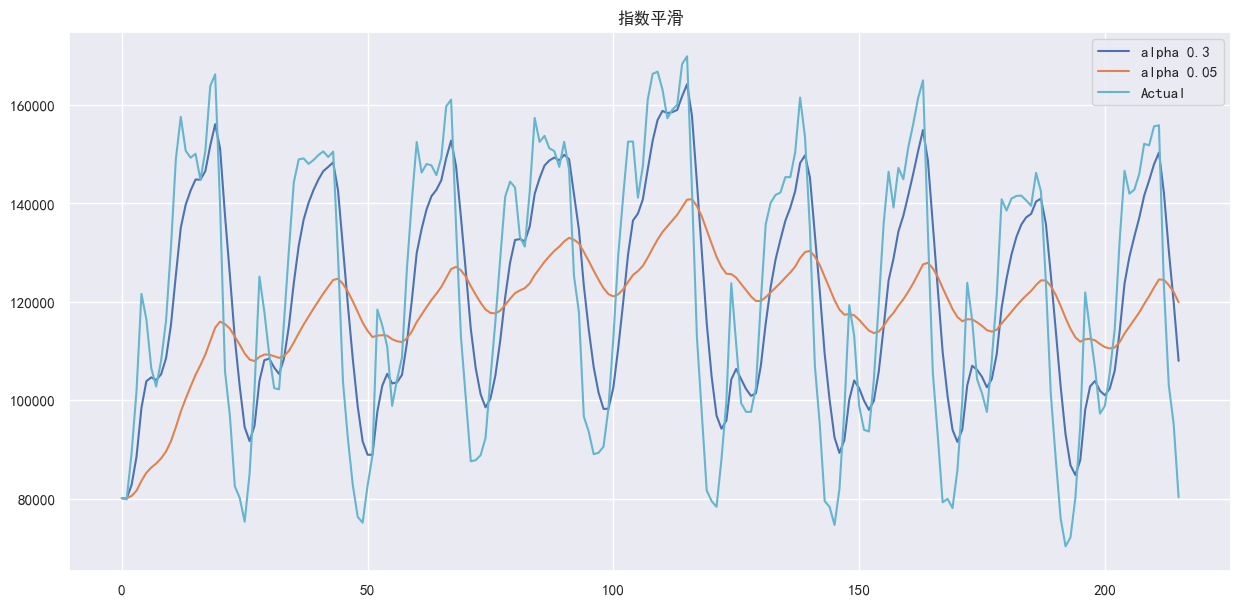

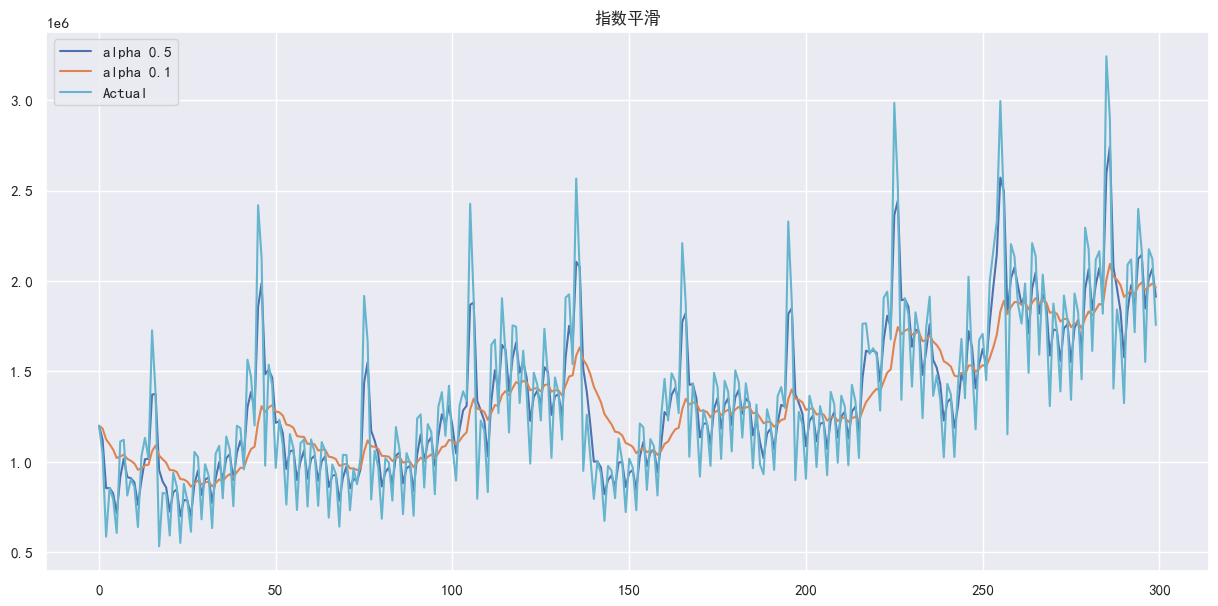

In [66]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def exponential_smoothing(series, alpha):
    """
    :param series: time series
    :param alpha: alpha
    :return:
    """
    result = [series[0]]  #the first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result


def plotExponentialSmoothing(series, alphas):
    """
    :param series:
    :param alpha:
    :return:
    """
    # with plt.style.context('seaborn-white'):
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label='alpha {}'.format(alpha))
    plt.plot(series.values, 'c', label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('指数平滑')
    plt.grid(True)

    plt.show()


plotExponentialSmoothing(ad.Ads, [0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.5, 0.1])

#### 双参数指数平滑

+ 双参数指数平滑:两个参数之中,$alpha$影响时间序列自身变化趋势的平滑程度,$beta$影响趋势的平滑程度
+ 方程如下:

    $l_x = \alpha_y_x+(1-\alpha)(l_{x-1}+b_{x-1})\\$
    $b_X = \beta(l_x-l_{x-1})+(1-\beta)b_{x-1}\\$
    $\hat{y_{x+1}}=l_x+b_x\\$


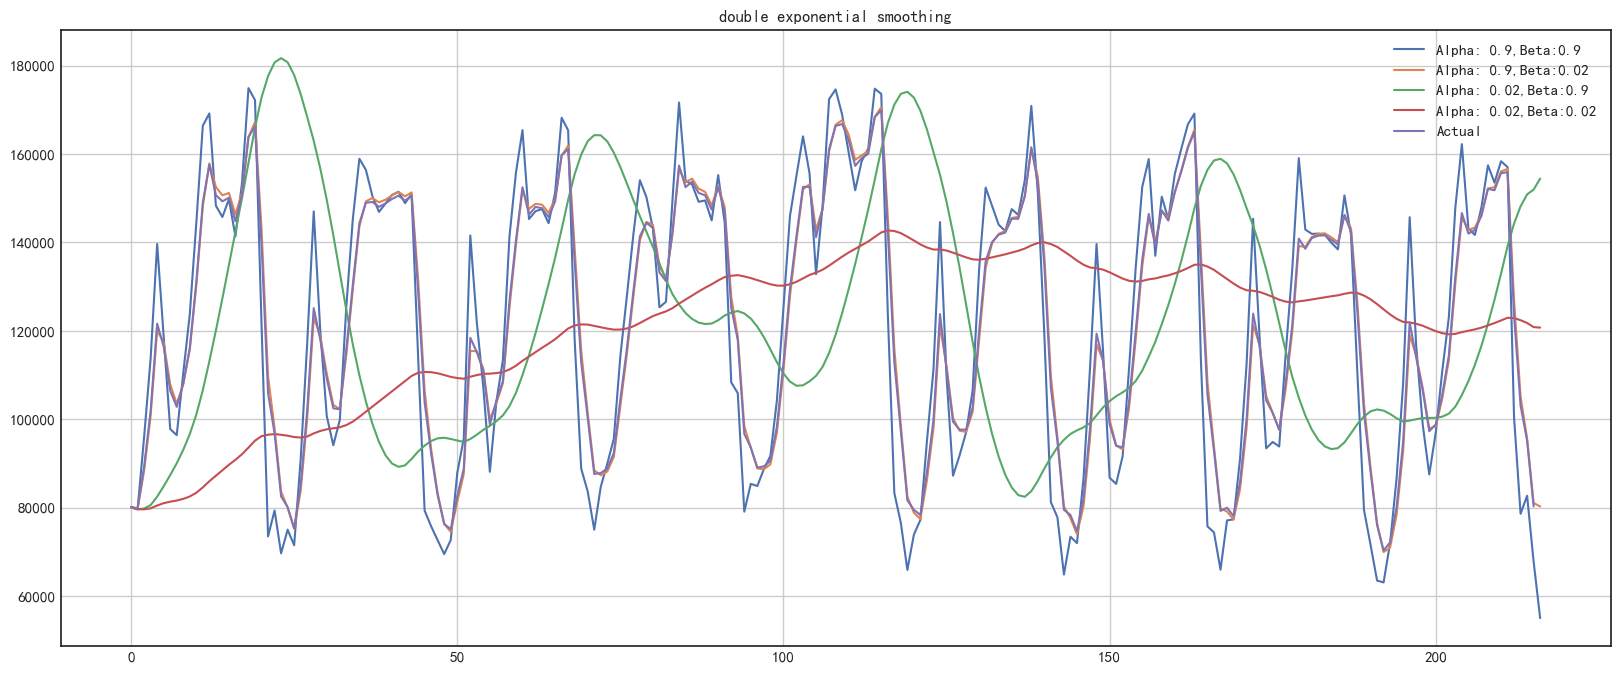

In [67]:
def double_exponential_smoothing(series, alpha, beta):
    """
    :param series:时间序列
    :param alpha:
    :param beta:
    :return:
    """
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            values = result[-1]
        else:
            values = series[n]
        last_level, level = level, alpha * values + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plot_double_exponential_smoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta),
                         label='Alpha: {},Beta:{}'.format(alpha, beta))
        plt.plot(series.values, label='Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('double exponential smoothing')
        plt.grid(True)


plot_double_exponential_smoothing(ad.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

#### 三指数平滑
+ 三参数指数平滑的方程:
$\hat{y}_{max)_x = l_{x-1}+b_{x-1}+s_{s-T}+m*d_{t-T}$
   $\hat{y}_{min}_x = l_{x-1} + b_{x-1}+s_{x-T}-m*d_{t-T}$
   $d_t= \gamma|y_t-\hat{y}_t|+(1-\gamma)d_{t-T}$

In [68]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen * j:self.slen * j + self.slen]) / float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (
                        smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1 - self.gamma) * self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])


### 时间序列交叉验证

In [69]:
from sklearn.model_selection import TimeSeriesSplit


def timeSeriesCVscore(params, series, loss_function=mean_absolute_error, slen=24):
    """
    :param params:
    :param loss_function:
    :param slen:
    :return:Errors on CV
    """
    errors = []
    values = series.values
    alpha, beta, gamma = params  #解包运算
    tscv = TimeSeriesSplit(n_splits=3)
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))


In [70]:
data = ad.Ads[:-20]

x = [0, 0, 0]

# 最小化损失函数
opt = minimize(
    timeSeriesCVscore,
    x0=x,
    args=(data, mean_absolute_error), method='TNC', bounds=((0, 1), (0, 1), (0, 1))
)

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3
)

model.triple_exponential_smoothing()


0.1154405061463532 0.0010344554184464894 0.006531320883586544


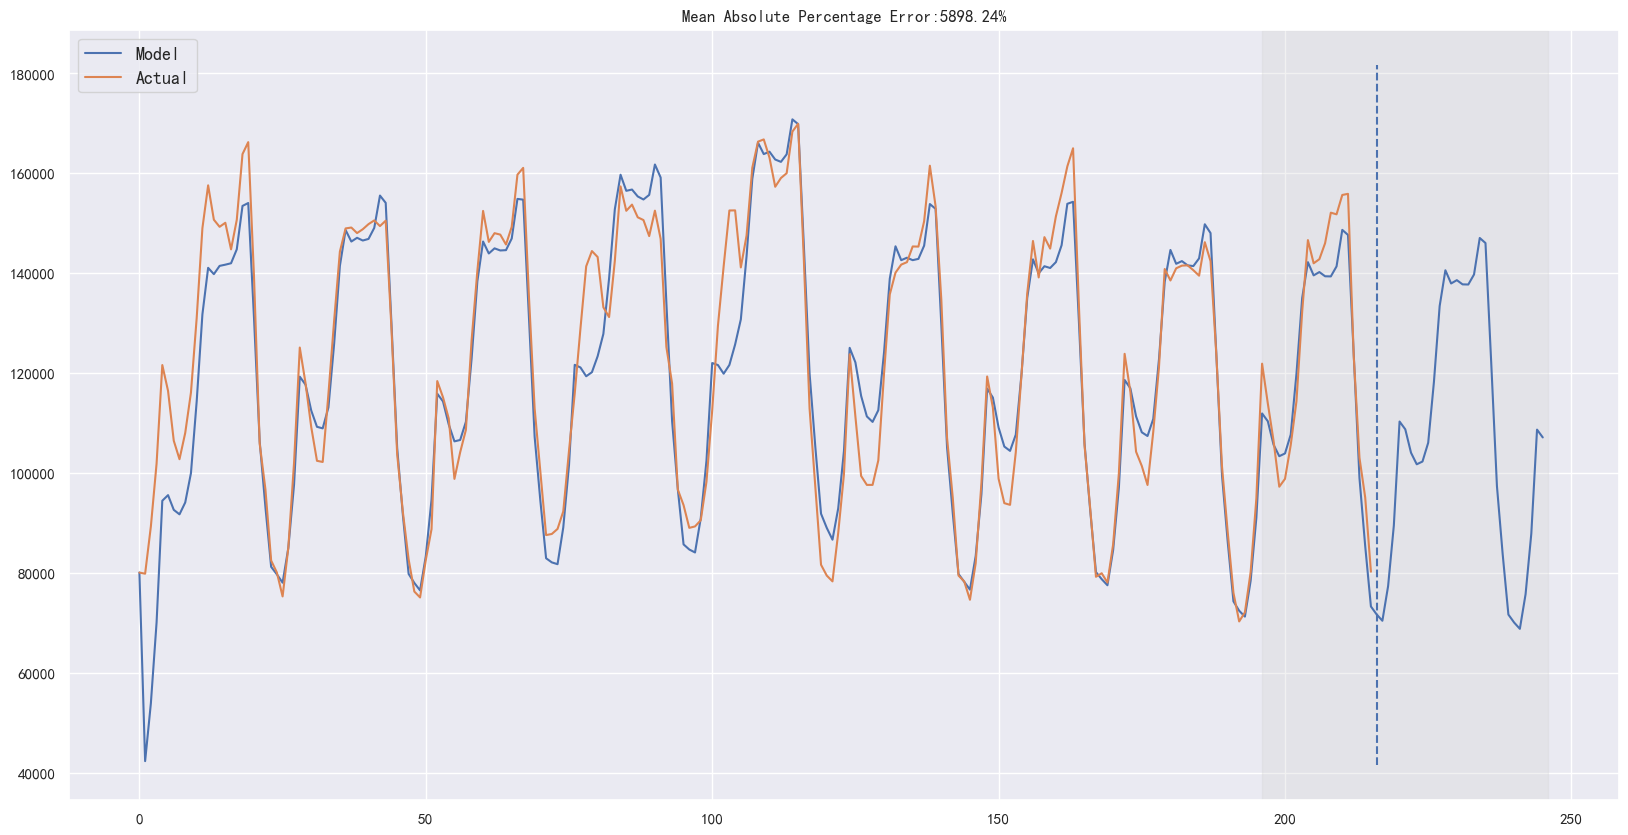

In [71]:
def plot_holt_winters(series, plot_intervals=False, plot_anomalies=False):
    """
    :param series:
    :param plot_intervals:
    :param plot_anomalies:
    :return:
    """
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label='Model')
    plt.plot(series.values, label='Actual')
    error = mean_absolute_error(series.values, model.result[:len(series)])
    plt.title('Mean Absolute Percentage Error:{0:.2f}%'.format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values < model.LowerBond[:len(series)]]
        anomalies[series.values > model.series > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    if plot_intervals:
        plt.plot(model.UpperBond, 'r--', alpha=0.5, label='Upper/Lower Confidence')
        plt.plot(model.LowerBond, 'r--', alpha=0.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.2, color='grey')

    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='best', fontsize=13)


plot_holt_winters(ad.Ads)

ValueError: ('Lengths must match to compare', (196,), (216,))

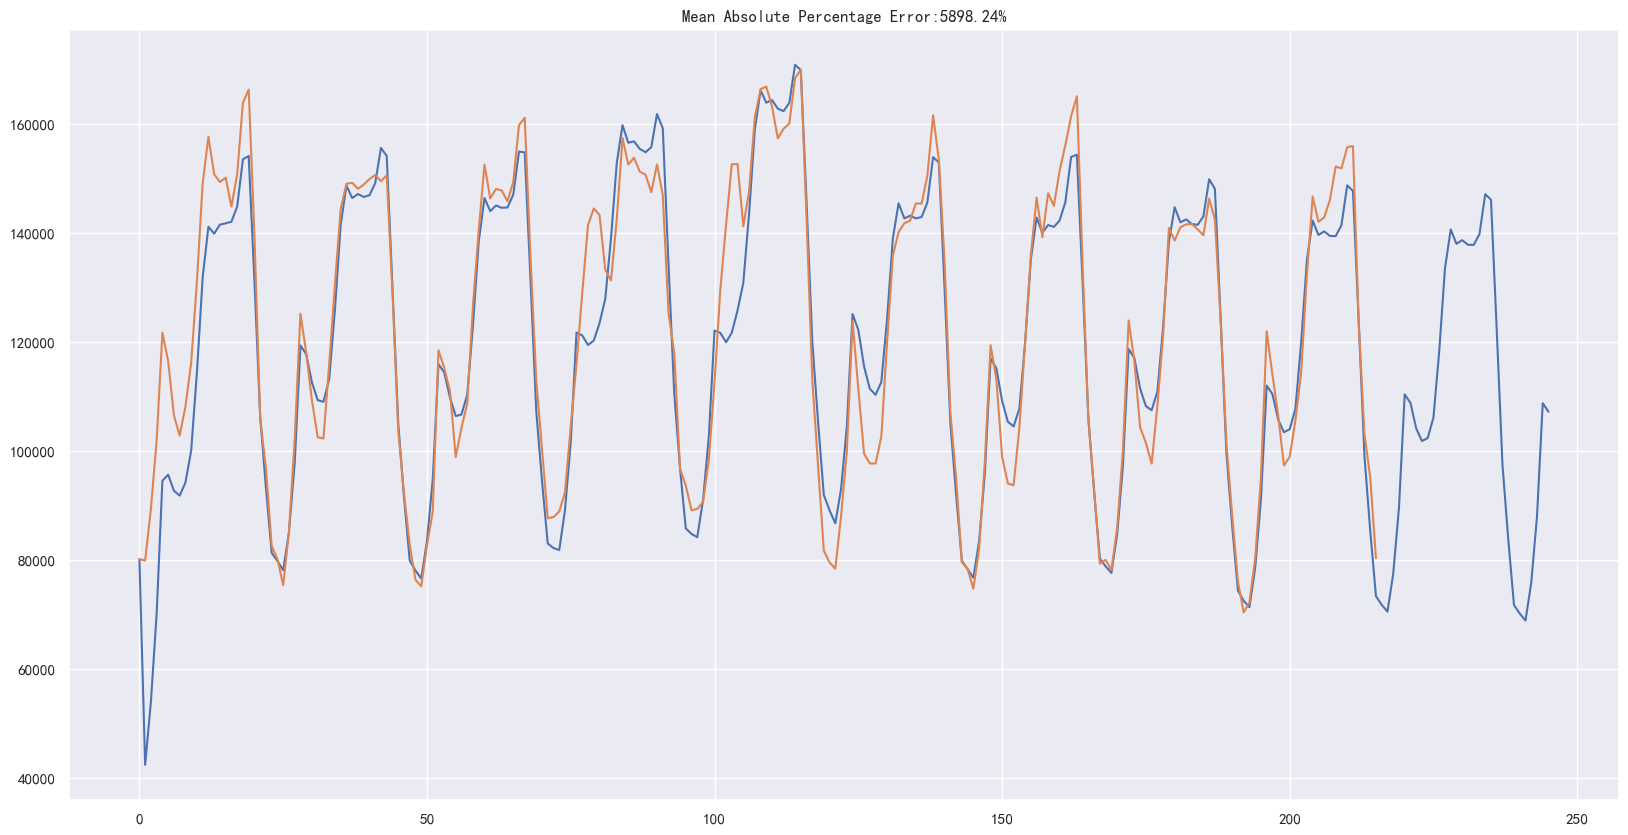

In [72]:
plot_holt_winters(ad.Ads, plot_anomalies=True, plot_intervals=True)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ExpSmoothingModel = ExponentialSmoothing(ad.Ads, missing='drop')
ExpSmoothingModel.initialize()